In [0]:
import os
import numpy as np
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
root_dir = '/content/drive/'
drive.mount(root_dir, force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
exec(open('/content/drive/My Drive/ML_Project/prepare_data.ipynb').read())

In [0]:
classes = ['tree', 't-shirt', 'ice cream', 'fish', 'face', 'car', 'bowtie', 'apple', 'flamingo', 'sheep']

In [0]:
def load_data(batch_size = 128):
    """
    Returns a list of PyTorch DataLoaders in order of train, validation, and test loaders
    """
    dirnames = [root_dir + 'My Drive/ML_Project/Train/', root_dir + 'My Drive/ML_Project/Validation/', root_dir + 'My Drive/ML_Project/Test/']
    loaders = []

    scaler = StandardScaler()
    for dirname in dirnames:
        dataname = os.listdir(dirname)[0]
        X = np.load(dirname + dataname)['data'].reshape(-1, 28, 28)
        ys = np.load(dirname + dataname)['target']

        xs = np.copy(X)
        for sample in range(len(X)):
          samplex = X[sample,:,:]
          xs[sample,:,:] = scaler.fit_transform(samplex)

        print(f'Loading {dataname} into Pytorch Dataloader ... Xs shape: {xs.shape}, Ys shape: {ys.shape}')
        loaders.append(DataLoader(TensorDataset(Tensor(xs), Tensor(ys)), batch_size = batch_size, shuffle=True))
    
    return loaders

In [0]:
class ClassifyNet(nn.Module):
    def __init__(self, num_classes):
        super(ClassifyNet, self).__init__()
        self.num_classes = num_classes
        self.dropout = nn.Dropout(p=0.2)
        self.bn = nn.BatchNorm2d(3)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.mp = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(3 * 14 * 14, 1000)
        self.fc2 = nn.Linear(1000, 300)
        self.fc3 = nn.Linear(300, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.mp(F.relu(self.conv3(x)))
        # Resize from (batch_size, num_classes, w, h) to (batch_size,num_classes*w*h)
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.softmax(self.fc3(x), dim = 1)
        return x

In [0]:
def evaluate_model(model, dataloader, criterion = nn.CrossEntropyLoss()):
    """
    Calculates the average loss and accuracy of the model on a dataset
    """
    model.eval() # Notify all layers we're in eval mode instead of training mode
    avg_loss, total, correct = 0, 0, 0
    
    for batch_idx, (xs, ys) in enumerate(dataloader):
        output = model.forward(xs.unsqueeze(dim=1))
        avg_loss += criterion(output, ys.long())
        _, predictions = torch.max(output.data, 1)
        total += ys.size(0)
        correct += (predictions == ys).sum().item()
    
    return avg_loss / len(dataloader), 100 * correct / total


In [0]:
def train(model, optimizer, trainloader, validloader, curr_epoch = 0, num_epochs = 25, criterion = nn.CrossEntropyLoss()):
    model.train()
    print('\n')
    for epoch in range(curr_epoch, curr_epoch + num_epochs):
        avg_loss = 0.0
        # Training Step:
        # iterate through every batch in training set
        for batch_idx, (xs, ys) in enumerate(trainloader):
            # reset stored gradients to 0
            optimizer.zero_grad()
            output = model(xs.unsqueeze(dim=1))
            loss = criterion(output, ys.long())
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

        # Validation step: 
        valid_loss, valid_acc = evaluate_model(model, validloader)
        print(f'Epoch {epoch+1}  | Training loss: {avg_loss / len(trainloader) : .2f}  |  Validation loss: {valid_loss: .2f}  |  Validation accuracy: {valid_acc : .2f}')


In [0]:
classifier = ClassifyNet(num_classes = 10)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

#optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-3, momentum=0.09)

In [8]:
trainloader, validloader, testloader  = load_data(batch_size = 256)

Loading Train.npz into Pytorch Dataloader ... Xs shape: (84000, 28, 28), Ys shape: (84000,)
Loading Validation.npz into Pytorch Dataloader ... Xs shape: (36000, 28, 28), Ys shape: (36000,)
Loading Test.npz into Pytorch Dataloader ... Xs shape: (30000, 28, 28), Ys shape: (30000,)


Training the classifier

In [0]:
train(classifier, optimizer, trainloader, validloader, curr_epoch = 0, num_epochs = 30)

# Test performance:
test_loss, test_acc = evaluate_model(classifier, testloader)
print(f'\nTest loss: {test_loss: .2f} | Test accuracy: {test_acc : .2f}')



Epoch 1  | Training loss:  1.67  |  Validation loss:  1.62  |  Validation accuracy:  84.15
Epoch 2  | Training loss:  1.59  |  Validation loss:  1.57  |  Validation accuracy:  88.67
Epoch 3  | Training loss:  1.56  |  Validation loss:  1.56  |  Validation accuracy:  90.24
Epoch 4  | Training loss:  1.55  |  Validation loss:  1.55  |  Validation accuracy:  91.04
Epoch 5  | Training loss:  1.54  |  Validation loss:  1.55  |  Validation accuracy:  91.55
Epoch 6  | Training loss:  1.53  |  Validation loss:  1.54  |  Validation accuracy:  91.94
Epoch 7  | Training loss:  1.53  |  Validation loss:  1.54  |  Validation accuracy:  91.78
Epoch 8  | Training loss:  1.52  |  Validation loss:  1.54  |  Validation accuracy:  92.23
Epoch 9  | Training loss:  1.52  |  Validation loss:  1.53  |  Validation accuracy:  92.76
Epoch 10  | Training loss:  1.51  |  Validation loss:  1.54  |  Validation accuracy:  92.47
Epoch 11  | Training loss:  1.51  |  Validation loss:  1.54  |  Validation accuracy:  9

In [0]:
torch.save(classifier.state_dict(), '/content/drive/My Drive/ML_Project/cl1.pt')

# **Testing generated outputs**

In [9]:
classifier = ClassifyNet(num_classes = 10)

checkpoint = torch.load('/content/drive/My Drive/ML_Project/cl1.pt')
classifier.load_state_dict(checkpoint)

<All keys matched successfully>

In [0]:
classes = ['tree', 't-shirt', 'ice cream', 'fish', 'face', 'car', 'bowtie', 'apple', 'flamingo', 'sheep']

In [42]:
    dirname = root_dir + 'My Drive/ML_Project/VAE_outputs/'
    print('Files:',os.listdir(dirname))
    files = os.listdir(dirname)
    files.remove('Comparisons')
    files.remove('old_face_generated.npy')

    base_dir = root_dir + 'My Drive/ML_Project/Dataset'
    file_names = os.listdir(base_dir)

    loaders = []
    batch_size = 128

    scaler = StandardScaler()

    for i in range(len(files)):
        dataname = files[i]
        print(dataname)
        X = np.load(dirname + dataname)
        X = X.reshape(-1, 28, 28)
        search = dataname[:-14]
        if search not in classes:
          print(search)
          continue
        c = file_names.index(search+'.npy')
        ys = np.ones((len(X),))*c

        xs = np.copy(X)
        for sample in range(len(X)):
          samplex = X[sample,:,:]
          xs[sample,:,:] = scaler.fit_transform(samplex)

        print(f'Loading {dataname} into Pytorch Dataloader ... Xs shape: {xs.shape}, Ys shape: {ys.shape}')
        loaders.append(DataLoader(TensorDataset(Tensor(xs), Tensor(ys)), batch_size = batch_size, shuffle=True))


Files: ['car_generated.npy', 'bowtie_generated.npy', 'Comparisons', 'baseball_generated.npy', 'tree_generated.npy', 't-shirt_generated.npy', 'ice cream_generated.npy', 'fish_generated.npy', 'apple_generated.npy', 'leaf_generated.npy', 'old_face_generated.npy', 'face_generated.npy', 'flamingo_generated.npy', 'sheep_generated.npy']
car_generated.npy
Loading car_generated.npy into Pytorch Dataloader ... Xs shape: (10001, 28, 28), Ys shape: (10001,)
bowtie_generated.npy
Loading bowtie_generated.npy into Pytorch Dataloader ... Xs shape: (10001, 28, 28), Ys shape: (10001,)
baseball_generated.npy
baseball
tree_generated.npy
Loading tree_generated.npy into Pytorch Dataloader ... Xs shape: (10001, 28, 28), Ys shape: (10001,)
t-shirt_generated.npy
Loading t-shirt_generated.npy into Pytorch Dataloader ... Xs shape: (10001, 28, 28), Ys shape: (10001,)
ice cream_generated.npy
Loading ice cream_generated.npy into Pytorch Dataloader ... Xs shape: (10001, 28, 28), Ys shape: (10001,)
fish_generated.npy

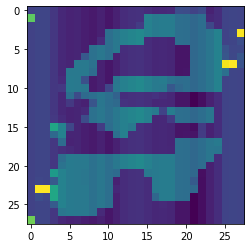

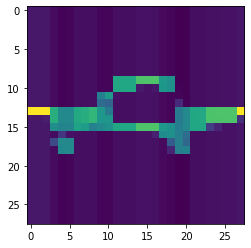

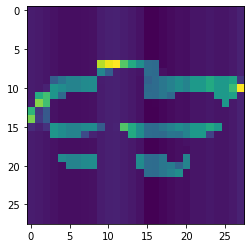

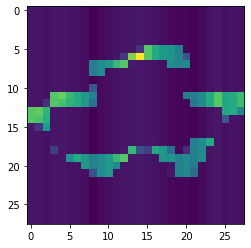

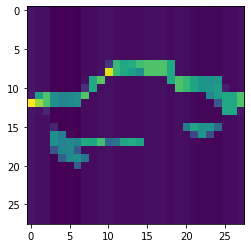

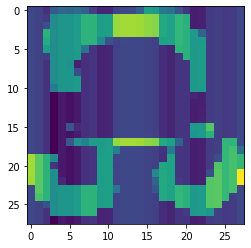

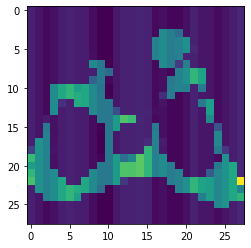

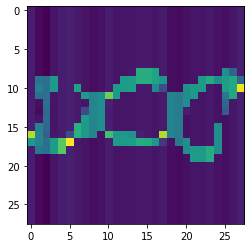

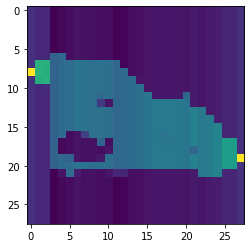

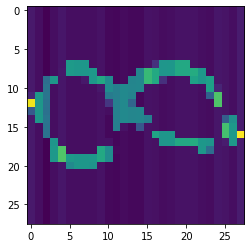

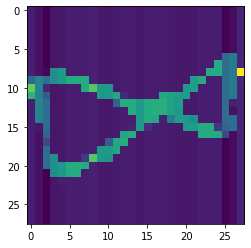

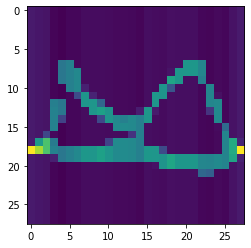

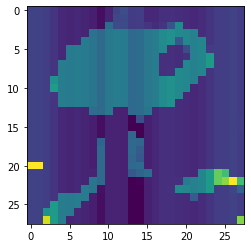

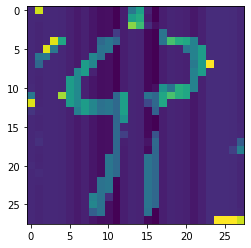

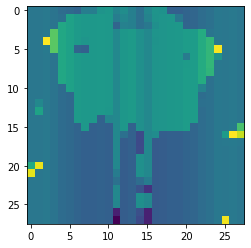

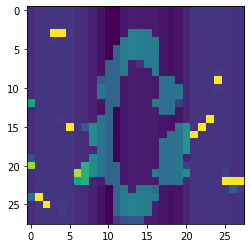

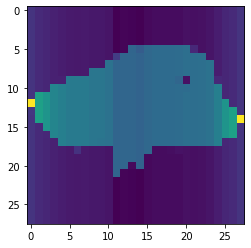

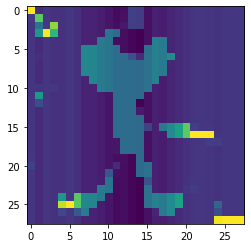

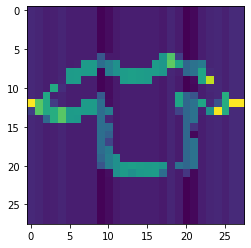

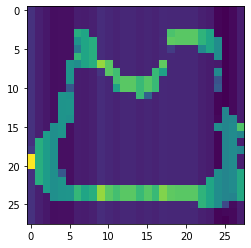

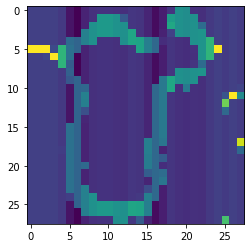

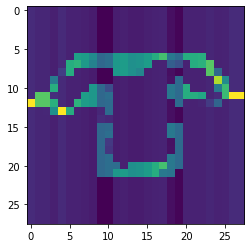

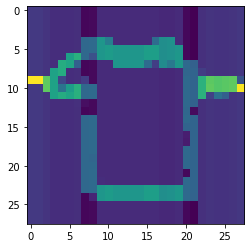

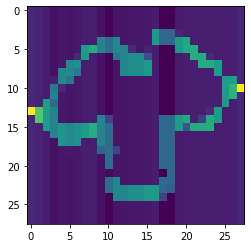

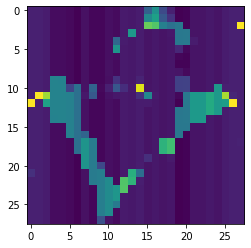

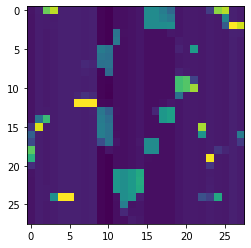

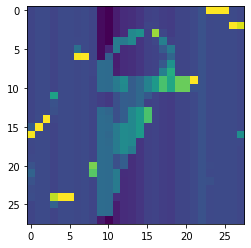

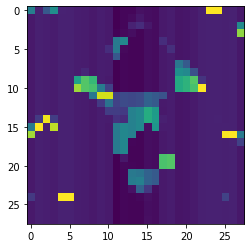

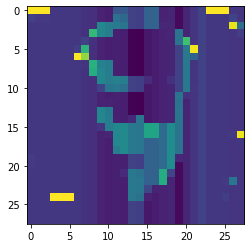

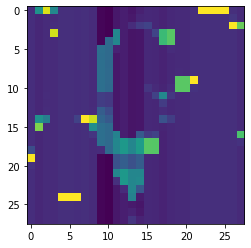

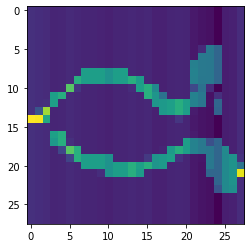

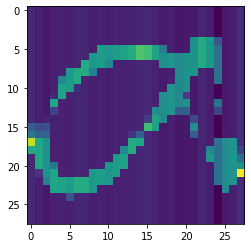

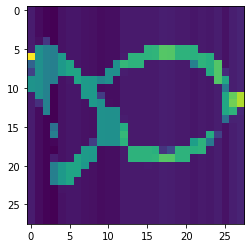

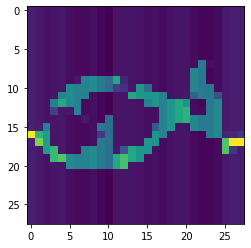

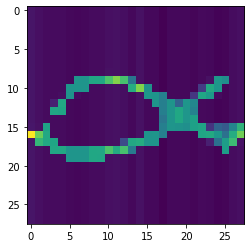

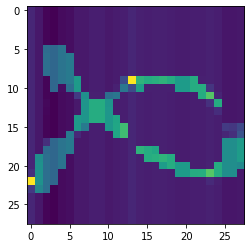

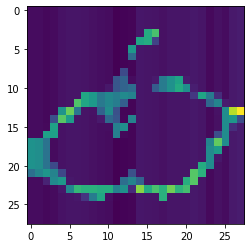

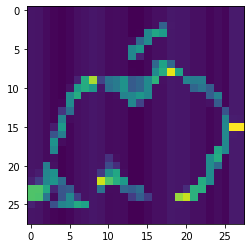

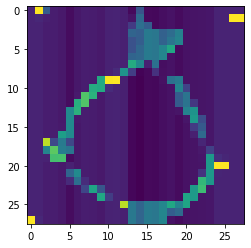

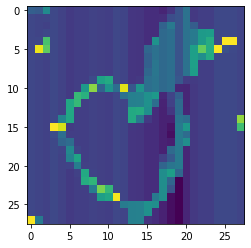

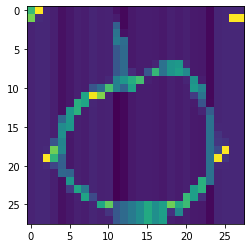

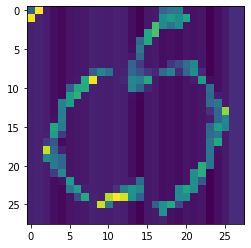

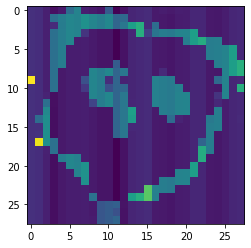

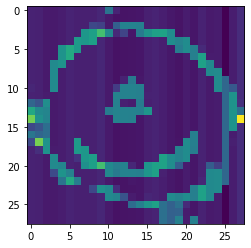

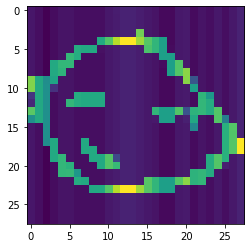

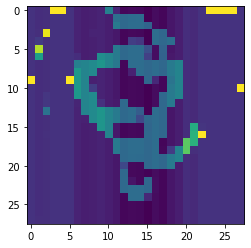

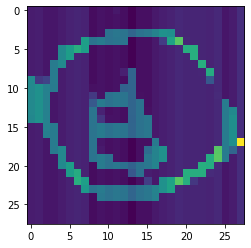

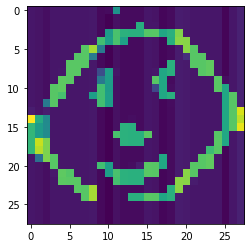

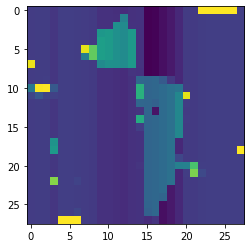

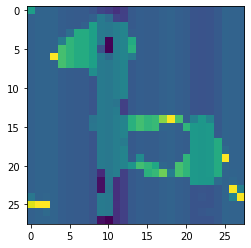

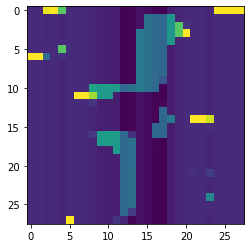

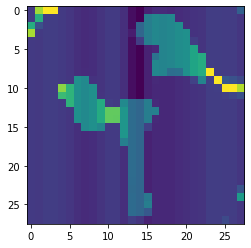

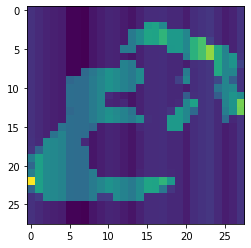

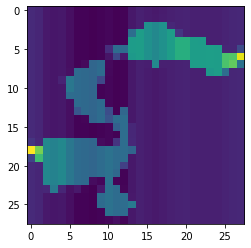

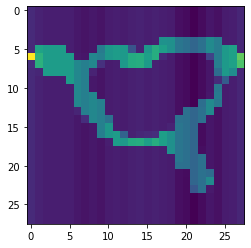

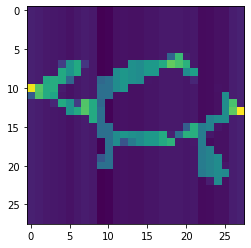

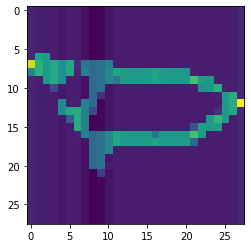

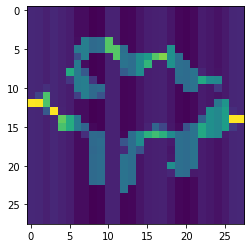

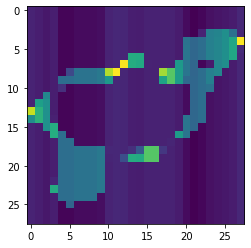

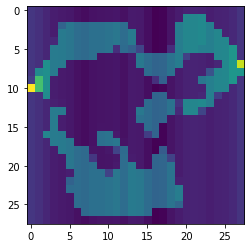

In [54]:
import matplotlib.pyplot as plt
for i in range(len(classes)):
  data = loaders[i]
  j = 0
  for batch_idx, (xs, ys) in enumerate(data):
    plt.imshow(xs[0,:,:]*2)
    plt.show()
    j+=1
    if j > 5:
      break

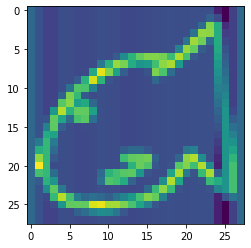

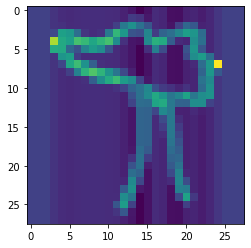

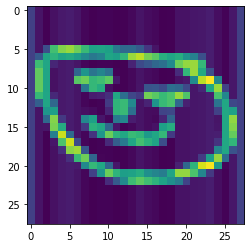

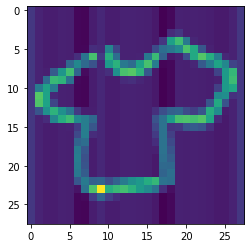

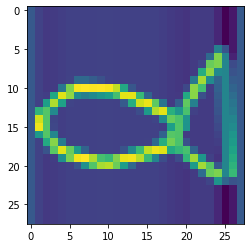

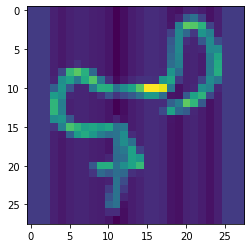

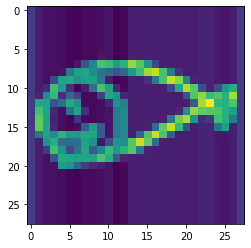

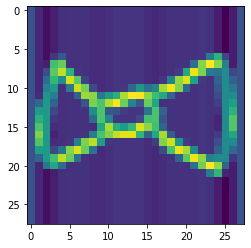

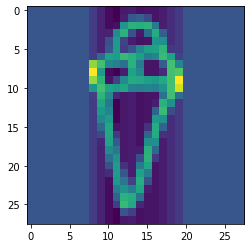

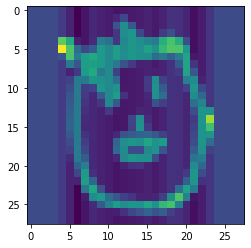

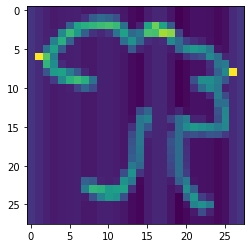

In [55]:
import matplotlib.pyplot as plt
j = 0
for batch_idx, (xs, ys) in enumerate(trainloader):
  plt.imshow(xs[0,:,:]*2)
  plt.show()
  j+=1
  if j > 10:
    break

In [43]:
print(len(loaders))
for i in range(len(classes)):
  test_loss, test_acc = evaluate_model(classifier, loaders[i])
  print('For class', classes[i],  'accuracy is',test_acc)

10
For class tree accuracy is 70.05299470052995
For class t-shirt accuracy is 90.21097890210979
For class ice cream accuracy is 87.71122887711229
For class fish accuracy is 96.64033596640336
For class face accuracy is 30.40695930406959
For class car accuracy is 68.08319168083192
For class bowtie accuracy is 91.26087391260874
For class apple accuracy is 79.03209679032096
For class flamingo accuracy is 85.17148285171483
For class sheep accuracy is 81.74182581741826


In [0]:

# Class accuracy
classifier = ClassifyNet(num_classes = 10)
classes = ['tree', 't-shirt', 'ice cream', 'fish', 'face', 'car', 'bowtie', 'apple', 'flamingo', 'sheep']
checkpoint = torch.load('/content/drive/My Drive/ML_Project/cl1.pt')
classifier.load_state_dict(checkpoint)

class_correct, class_total  = [0 for i in range(10)], [0 for i in range(10)]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = classifier.forward(images.unsqueeze(dim=1))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(c)):
            label = int(labels[i].data.numpy())
            if c[i] == True:
              class_correct[label] += 1
            class_total[label] += 1


print(class_total)
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

#test_loss, test_acc = evaluate_model(classifier, testloader)
#print(f'\nTest loss: {test_loss: .2f} | Test accuracy: {test_acc : .2f}')

remove = ['leaf', 'baseball']
classes = ['flamingo', 'sheep']

[3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]
Accuracy of  tree : 90 %
Accuracy of t-shirt : 95 %
Accuracy of ice cream : 95 %
Accuracy of  fish : 86 %
Accuracy of  face : 90 %
Accuracy of   car : 94 %
Accuracy of bowtie : 91 %
Accuracy of apple : 96 %
Accuracy of flamingo : 93 %
Accuracy of sheep : 88 %


# **Training a saved model**

In [0]:
torch.save({'model_state_dict': classifier.state_dict(),'optimizer_state_dict': optimizer.state_dict()}, '/content/drive/My Drive/ML_Project/checkpoint.pt')

In [0]:
# More training:
# Continued training: ....
checkpoint = torch.load('/content/drive/My Drive/ML_Project/checkpoint.pt')
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train(classifier, optimizer, trainloader, validloader, curr_epoch = 46, num_epochs = 10)

# Test performance:
test_loss, test_acc = evaluate_model(classifier, testloader)
print(f'\nTest loss: {test_loss: .2f} | Test accuracy: {test_acc : .2f}')



Epoch 47  | Training loss:  1.57  |  Validation loss:  2.28  |  Validation accuracy:  17.78
Epoch 48  | Training loss:  2.36  |  Validation loss:  2.36  |  Validation accuracy:  10.00
Epoch 49  | Training loss:  2.36  |  Validation loss:  2.36  |  Validation accuracy:  10.00
Epoch 50  | Training loss:  2.36  |  Validation loss:  2.36  |  Validation accuracy:  10.00
Epoch 51  | Training loss:  2.36  |  Validation loss:  2.36  |  Validation accuracy:  10.00


KeyboardInterrupt: ignored